In [5]:
import pandas as pd
import pymongo
import config
import database as db
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import requests 
import zipfile

warnings.filterwarnings('ignore')

In [51]:
def get_market_year(row):
    year = row['Year']
    week = row['Week']
    culture = row['Culture']
    if culture in ['Blé tendre', 'Blé dur']:
        if week >= 36:
            market_year = f"{year}/{year + 1}"
        else:
            market_year = f"{year - 1}/{year}"
    else:
        if 9 <= week <= 49:
            market_year = f"{year - 1}/{year}"
        else:
            market_year = f"{year - 1}/{year}"
    return market_year

In [24]:
def get_yields():
    url = 'https://visionet.franceagrimer.fr/Pages/OpenDocument.aspx?fileurl=SeriesChronologiques%2fproductions%20vegetales%2fgrandes%20cultures%2fsurfaces%2cproductions%2crendements%2fSCR-GRC-hist_dep_surface_prod_cult_cer-A24.zip&telechargersanscomptage=oui'
    try:
        r = requests.get(url)
        r.raise_for_status()
        with open("yields/yields_report.zip", "wb") as f:
            f.write(r.content)
        print("File downloaded successfully!")

        with zipfile.ZipFile('yields/yields_report.zip', 'r') as zip_ref:
            zip_ref.extractall('yields')
        print(f"Files extracted")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    df = pd.read_csv('yields/SCR-GRC-hist_dep_surface_prod_cult_cer-A24.csv', encoding='ISO-8859-1', sep=';')
    return df

In [71]:
df = get_yields()
df['DEP'] = df['DEP'].str.replace(' ', '')
df['CULT_SURF'] = df['CULT_SURF'].str.replace(',','.').astype(float)
df['CULT_REND'] = df['CULT_REND'].str.replace(',','.').astype(float)
df['CULT_PROD'] = df['CULT_PROD'].str.replace(',','.').astype(float)
dfYieldsNA = df[df['DEP'].isin(['16','17','19','23','24','33','40','47','64','79','86','87'])]
dfYieldsNA

File downloaded successfully!
Files extracted


,ESPECES,DEP,DEPARTEMENT,REGION,ANNEE,CULT_SURF,CULT_REND,CULT_PROD
1275,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2000,460.0,45.00,2070.0
1276,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2001,500.0,40.00,2000.0
1277,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2002,1145.0,50.59,5792.5
1278,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2003,972.0,43.76,4253.0
1279,Autres céréales,16,CHARENTE,NOUVELLE AQUITAINE,2004,1250.0,50.00,6250.0
...,...,...,...,...,...,...,...,...
79170,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2020,399.0,80.00,3192.0
79171,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2021,399.0,85.00,3391.5
79172,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2022,399.0,90.00,3591.0
79173,dont maïs grain irrigué,87,HAUTE-VIENNE,NOUVELLE AQUITAINE,2023,399.0,105.00,4189.5


In [53]:
cursorDev = db.get_database_dev_cond_region().find({})
dfCondition = pd.DataFrame(list(cursorDev)).sort_values(by='Date', ascending=True)
dfCondition = dfCondition[['Culture', 'Date', 'Week', 'Year', 'Région', 'Très mauvaises', 'Mauvaises', 'Assez bonnes', 'Bonnes', 'Très bonnes']]
dfCondition = dfCondition[dfCondition['Région'] == 'Nouvelle-Aquitaine']
dfCondition['MarketYear'] = dfCondition.apply(get_market_year, axis=1)
dfCondition

,Culture,Date,Week,Year,Région,Très mauvaises,Mauvaises,Assez bonnes,Bonnes,Très bonnes,MarketYear
9660,Blé tendre,2014-09-29,40,2014,Nouvelle-Aquitaine,NaN,NaN,NaN,NaN,NaN,2014/2015
4371,Blé dur,2014-10-06,41,2014,Nouvelle-Aquitaine,NaN,NaN,NaN,NaN,NaN,2014/2015
9661,Blé tendre,2014-10-06,41,2014,Nouvelle-Aquitaine,NaN,NaN,NaN,100.00,NaN,2014/2015
4372,Blé dur,2014-10-13,42,2014,Nouvelle-Aquitaine,NaN,NaN,NaN,100.00,NaN,2014/2015
9662,Blé tendre,2014-10-13,42,2014,Nouvelle-Aquitaine,NaN,NaN,NaN,100.00,NaN,2014/2015
...,...,...,...,...,...,...,...,...,...,...,...
4786,Blé dur,2024-05-06,19,2024,Nouvelle-Aquitaine,6.65,7.78,23.55,62.02,NaN,2023/2024
2754,Maïs grain,2024-05-06,19,2024,Nouvelle-Aquitaine,NaN,NaN,5.08,94.92,NaN,2023/2024
2755,Maïs grain,2024-05-13,20,2024,Nouvelle-Aquitaine,2.03,2.03,8.64,87.30,NaN,2023/2024
10092,Blé tendre,2024-05-13,20,2024,Nouvelle-Aquitaine,2.26,22.15,34.91,39.21,1.47,2023/2024


In [78]:
dfConditionBleTendreYearMean = dfCondition[dfCondition['Culture'] == 'Blé tendre'].groupby('MarketYear').mean().fillna(0)
dfConditionBleTendreYearMean['Year Recolte'] = dfConditionBleTendreYearMean.index.str.split('/').str[1].astype(int)
dfConditionBleTendreYearMean

,Week,Year,Très mauvaises,Mauvaises,Assez bonnes,Bonnes,Très bonnes,Year Recolte
MarketYear,,,,,,,,
2014/2015,24.409091,2014.772727,0.000000,2.245263,11.609737,79.542326,9.293158,2015
2015/2016,24.733333,2015.755556,1.731111,6.179744,13.348864,63.295455,17.171136,2016
2016/2017,24.409091,2016.772727,2.732000,6.237500,12.373256,68.814884,13.478372,2017
2017/2018,25.021739,2017.739130,0.380000,3.744750,15.133556,80.697111,0.852564,2018
2018/2019,24.409091,2018.772727,0.000000,2.942273,17.346512,76.525814,6.855862,2019
2019/2020,24.409091,2019.772727,2.748649,12.838158,33.031500,55.333953,0.606250,2020
2020/2021,24.409091,2020.772727,0.848710,10.957742,26.784516,71.540698,1.012963,2021
2021/2022,24.409091,2021.772727,5.784444,10.863600,11.887838,79.581163,2.017419,2022
2022/2023,24.733333,2022.755556,0.000000,2.805000,8.685625,85.155000,10.834516,2023


In [80]:
dfYieldsNA = dfYieldsNA.rename(columns={'ANNEE':'Year'})
dfYieldsNABleTendre = dfYieldsNA[dfYieldsNA['ESPECES'] == "Blé tendre d'hiver       "]
dfYieldsNABleTendreSum = dfYieldsNABleTendre.groupby('Year').sum()
dfYieldsNABleTendreSum['Year Recolte'] = dfYieldsNABleTendreSum.index.astype(int)
dfYieldsNABleTendreSum

,CULT_SURF,CULT_REND,CULT_PROD,Year Recolte
Year,,,,
2000,457370.0,671.00,2946943.0,2000
2001,395292.0,608.00,2281798.5,2001
2002,503621.0,744.00,3540249.2,2002
2003,447640.0,624.00,2637040.7,2003
2004,492935.0,715.00,3182810.4,2004
2005,502043.0,701.00,3256988.0,2005
2006,504986.0,684.00,3074731.5,2006
2007,494406.0,596.00,2771902.3,2007
2008,538580.0,669.00,3341121.1,2008


In [82]:
dfFinal = pd.merge(dfYieldsNABleTendreSum, dfConditionBleTendreYearMean, on='Year Recolte', how='inner')
dfFinal = dfFinal.iloc[:-1]
dfFinal

,CULT_SURF,CULT_REND,CULT_PROD,Year Recolte,Week,Year,Très mauvaises,Mauvaises,Assez bonnes,Bonnes,Très bonnes
0,535848.0,742.00,3605133.6,2015,24.409091,2014.772727,0.000000,2.245263,11.609737,79.542326,9.293158
1,537094.0,619.00,2967939.1,2016,24.733333,2015.755556,1.731111,6.179744,13.348864,63.295455,17.171136
2,514039.0,723.00,3256292.2,2017,24.409091,2016.772727,2.732000,6.237500,12.373256,68.814884,13.478372
3,503335.0,650.00,3056152.5,2018,25.021739,2017.739130,0.380000,3.744750,15.133556,80.697111,0.852564
4,516415.0,827.00,3832533.5,2019,24.409091,2018.772727,0.000000,2.942273,17.346512,76.525814,6.855862
5,357124.0,575.00,1861867.5,2020,24.409091,2019.772727,2.748649,12.838158,33.031500,55.333953,0.606250
6,503255.0,667.00,3033914.0,2021,24.409091,2020.772727,0.848710,10.957742,26.784516,71.540698,1.012963
7,477005.0,601.01,2527799.0,2022,24.409091,2021.772727,5.784444,10.863600,11.887838,79.581163,2.017419
8,491730.0,725.00,3189999.0,2023,24.733333,2022.755556,0.000000,2.805000,8.685625,85.155000,10.834516


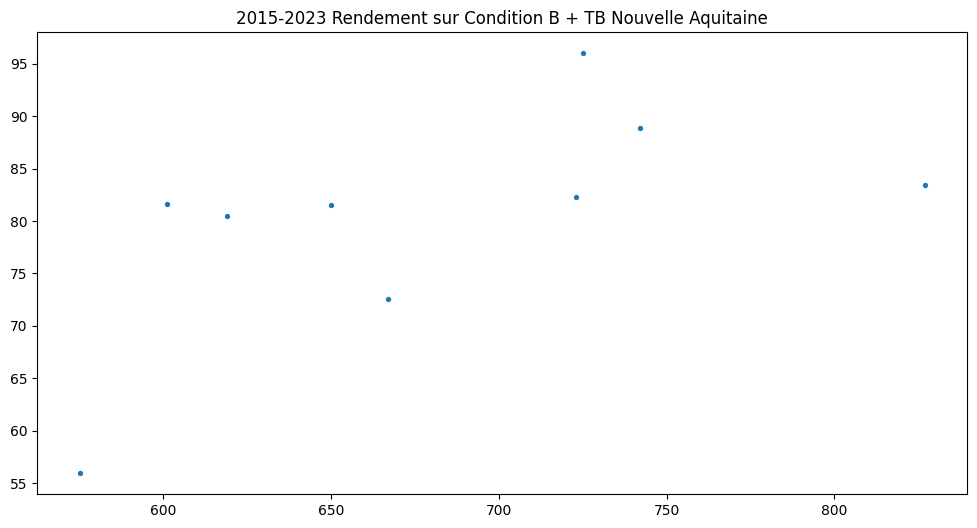

In [84]:
x = dfFinal['CULT_REND']
y = dfFinal['Bonnes'] + dfFinal['Très bonnes']
plt.figure(figsize=(12, 6))
plt.scatter(x, y, s=8)
plt.title('2015-2023 Rendement sur Condition B + TB Nouvelle Aquitaine')
plt.show()

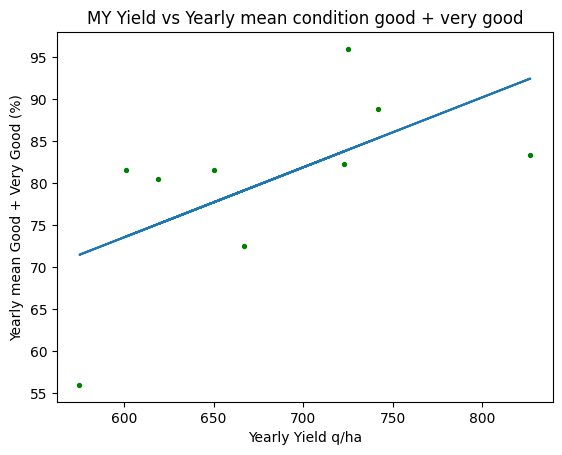

In [88]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) 

# Calculate y values for the regression line using list comprehension
y_pred = [slope * xi + intercept for xi in x]
# Create scatter plot
plt.scatter(x, y, color='green', s=8)
plt.title('MY Yield vs Yearly mean condition good + very good')
plt.xlabel('Yearly Yield q/ha')
plt.ylabel('Yearly mean Good + Very Good (%)')

# Add regression line to the plot
plt.plot(x, y_pred)
plt.show()

In [86]:
print(r_value)

0.600726302883034
